In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import tensorflow as tf

2025-05-25 15:29:41.623346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 15:29:42.121531: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-25 15:29:46.577690: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-25 15:29:51.168640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748186993.897145     896 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748186995.12

In [2]:
from memory_profiler import memory_usage
import time
import joblib

In [3]:
def Load_WISDM_dataset(file_path):
    cleaned_rows = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            # Line ends with ;, so we may get it as part of the last value
            if len(parts) == 6 or len(parts) == 7:  # Acceptable lines
                try:
                    user = int(parts[0])
                    activity = parts[1]
                    timestamp = int(parts[2])
                    x = float(parts[3])
                    y = float(parts[4])
                    z = float(parts[5].replace(';', ''))  # Clean the ;
                    cleaned_rows.append([user, activity, timestamp, x, y, z])
                except ValueError:
                    continue  # skip malformed lines

    columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
    df = pd.DataFrame(cleaned_rows, columns=columns)
    return df

In [4]:
df = Load_WISDM_dataset('datasets/WISDM/WISDM_raw.txt')

In [5]:
df = df.iloc[:500000].copy()
print(df['activity'].value_counts())
print(df.shape)
df.head()

activity
Walking       208519
Jogging       159792
Upstairs       53856
Downstairs     49607
Sitting        15561
Standing       12665
Name: count, dtype: int64
(500000, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [6]:
def extract_features_from_window(window):
    features = []

    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features += [
            data.mean(),
            data.std(),
            data.min(),
            data.max(),
            data.median(),
            np.sqrt(np.sum(data**2)),  # Energy
        ]
    return features


In [7]:
def create_feature_dataset(df, window_size=50, step_size=25):
    X_features = []
    y_labels = []

    for user_id in df['user'].unique():
        user_data = df[df['user'] == user_id]

        for i in range(0, len(user_data) - window_size, step_size):
            window = user_data.iloc[i:i+window_size]
            if len(window['activity'].unique()) == 1:
                features = extract_features_from_window(window)
                X_features.append(features)
                y_labels.append(window['activity'].iloc[0])

    return np.array(X_features), np.array(y_labels)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


In [9]:

X_50, y_50 = create_feature_dataset(df, window_size=50, step_size=25)
X_100, y_100 = create_feature_dataset(df, window_size=100, step_size=50)

print(X_50.shape, y_50.shape)
print(X_100.shape, y_100.shape)


(19631, 18) (19631,)
(9629, 18) (9629,)


In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode activity labels to integers
le = LabelEncoder()
y50_encoded = le.fit_transform(y_50)
y100_encoded = le.fit_transform(y_100)
classes = le.classes_

In [11]:
# Train/Test split with encoded labels
X50_train, X50_test, y50_train, y50_test = train_test_split(X_50, y50_encoded, test_size=0.2, random_state=42)
X100_train, X100_test, y100_train, y100_test = train_test_split(X_100, y100_encoded, test_size=0.2, random_state=42)

In [12]:
print("Input shape:", X50_test.shape[1])

Input shape: 18


In [13]:
import pandas as pd
import time
from memory_profiler import memory_usage
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# ----------- WINDOW SIZE 50 -----------
print("\n\n----------- WINDOW SIZE 50 -----------")
scaler_50 = StandardScaler()
X50_train = scaler_50.fit_transform(X50_train)
X50_test = scaler_50.transform(X50_test)

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale']}

grid_50 = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_50.fit(X50_train, y50_train)
best_C_50 = grid_50.best_params_['C']

print(f"\n[Window 50] Best Parameters: {grid_50.best_params_}")

# Detailed classification report for each C
for C in param_grid['C']:
    print(f"\n[Window 50] Classification Report for C = {C}")
    model = SVC(kernel='rbf', C=C, gamma='scale')
    model.fit(X50_train, y50_train)
    y_pred = model.predict(X50_test)
    
    report = classification_report(y50_test, y_pred, target_names=classes, digits=2, zero_division=0)
    print(report)

# Measure training time and memory usage for best model
best_model_50 = grid_50.best_estimator_

start_time = time.time()
mem_usage = memory_usage((best_model_50.fit, (X50_train, y50_train)), interval=0.1)
elapsed_time = (time.time() - start_time) * 1000

print(f"[Window 50] Training Time: {elapsed_time:.2f} ms")
print(f"[Window 50] Memory Usage: {max(mem_usage):.2f} MB")

# ----------- WINDOW SIZE 100 -----------
print("\n\n----------- WINDOW SIZE 100 -----------")
scaler_100 = StandardScaler()
X100_train = scaler_100.fit_transform(X100_train)
X100_test = scaler_100.transform(X100_test)

grid_100 = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_100.fit(X100_train, y100_train)
best_C_100 = grid_100.best_params_['C']

print(f"\n[Window 100] Best Parameters: {grid_100.best_params_}")

# Detailed classification report for each C
for C in param_grid['C']:
    print(f"\n[Window 100] Classification Report for C = {C}")
    model = SVC(kernel='rbf', C=C, gamma='scale')
    model.fit(X100_train, y100_train)
    y_pred = model.predict(X100_test)
    
    report = classification_report(
        y100_test, y_pred, target_names=classes, digits=2, zero_division=0
    )
    print(report)

# Measure training time and memory usage for best model
best_model_100 = grid_100.best_estimator_

start_time = time.time()
mem_usage = memory_usage((best_model_100.fit, (X100_train, y100_train)), interval=0.1)
elapsed_time = (time.time() - start_time) * 1000

print(f"[Window 100] Training Time: {elapsed_time:.2f} ms")
print(f"[Window 100] Memory Usage: {max(mem_usage):.2f} MB")




----------- WINDOW SIZE 50 -----------
Fitting 5 folds for each of 4 candidates, totalling 20 fits

[Window 50] Best Parameters: {'C': 100, 'gamma': 'scale'}

[Window 50] Classification Report for C = 0.1
              precision    recall  f1-score   support

  Downstairs       0.84      0.52      0.64       407
     Jogging       0.97      0.99      0.98      1279
     Sitting       0.99      0.86      0.92       106
    Standing       0.86      1.00      0.93        95
    Upstairs       0.84      0.43      0.57       428
     Walking       0.82      1.00      0.90      1612

    accuracy                           0.88      3927
   macro avg       0.89      0.80      0.82      3927
weighted avg       0.88      0.88      0.86      3927


[Window 50] Classification Report for C = 1
              precision    recall  f1-score   support

  Downstairs       0.85      0.70      0.77       407
     Jogging       0.99      0.99      0.99      1279
     Sitting       0.99      1.00      1.0

In [16]:

best_model_50 = grid_50.best_estimator_
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Get encoded label classes (integers)
label_ids = np.unique(y50_test)

# Display human-readable labels
display_names = le.inverse_transform(label_ids)

# Compute and display the confusion matrix
cm = confusion_matrix(y50_test, y50_pred, labels=label_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Window Size 50")
plt.show()

NameError: name 'y50_pred' is not defined

In [ ]:
best_model_100 = grid_100.best_estimator_

# Get encoded label classes (integers)
label_ids = np.unique(y100_test)

# Display human-readable labels
display_names = le.inverse_transform(label_ids)

# Compute and display the confusion matrix
cm = confusion_matrix(y100_test, y100_pred, labels=label_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Window Size 100")
plt.show()

In [14]:
import joblib
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Step 1: Load saved model and scaler
svm_model_50 = joblib.load("SVM_model_50.pkl")
scaler_50 = joblib.load("SVM_scaler_50.pkl")


# Step 3: Scale the test data
X50_test_scaled = scaler_50.transform(X50_test)

# Step 4: Predict and compute confusion matrix
y50_pred = svm_model_50.predict(X50_test_scaled)

cm50 = confusion_matrix(y50_test, y50_pred)
cr50 = classification_report(y50_test, y50_pred,)

print("SVM Confusion Matrix [WINDOW 50]:\n", cm50)
print("\nClassification Report:\n", cr50)

# Step 1: Load saved model and scaler
svm_model_100 = joblib.load("SVM_model_100.pkl")
scaler_100 = joblib.load("SVM_scaler_100.pkl")


# Step 3: Scale the test data
X100_test_scaled = scaler_100.transform(X100_test)

# Step 4: Predict and compute confusion matrix
y100_pred = svm_model_100.predict(X100_test_scaled)

cm100 = confusion_matrix(y100_test, y100_pred)
cr100 = classification_report(y100_test, y100_pred)

print("SVM Confusion Matrix [WINDOW 100]:\n", cm100)
print("\nClassification Report:\n", cr100)


SVM Confusion Matrix [WINDOW 50]:
 [[ 340    2    1    0   39   25]
 [   4 1270    0    0    2    3]
 [   0    0  106    0    0    0]
 [   0    0    0   95    0    0]
 [  32    6    0    0  356   34]
 [  16    0    0    0    9 1587]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85       407
           1       0.99      0.99      0.99      1279
           2       0.99      1.00      1.00       106
           3       1.00      1.00      1.00        95
           4       0.88      0.83      0.85       428
           5       0.96      0.98      0.97      1612

    accuracy                           0.96      3927
   macro avg       0.95      0.94      0.94      3927
weighted avg       0.96      0.96      0.96      3927

SVM Confusion Matrix [WINDOW 100]:
 [[175   0   0   0   7   5]
 [  1 623   0   0   1   1]
 [  0   0  50   0   0   0]
 [  0   0   0  51   0   0]
 [ 11   4   0   0 156  14]
 [  3   1   0   0   1 822]]

In [21]:
# 1D CNN

In [62]:

def create_sequence_dataset(df, window_size=50, step_size=25):
    X, y = [], []
    for i in range(0, len(df) - window_size, step_size):
        window = df.iloc[i:i+window_size]
        if len(window['activity'].unique()) == 1:  # Consistent label in window
            X.append(window[['x', 'y', 'z']].values)
            y.append(window['activity'].iloc[0])
    return np.array(X), np.array(y)


In [63]:
X_seq_50, y_seq_50 = create_sequence_dataset(df, window_size=50, step_size=25)
X_seq_100, y_seq_100 = create_sequence_dataset(df, window_size=100, step_size=50)


In [64]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y50_encoded = to_categorical(label_encoder.fit_transform(y_seq_50))
y100_encoded = to_categorical(label_encoder.transform(y_seq_100))  # same encoder


In [67]:
from sklearn.model_selection import train_test_split

X50_train, X50_test, y50_train, y50_test = train_test_split(X_seq_50, y50_encoded, test_size=0.2, random_state=42)
X100_train, X100_test, y100_train, y100_test = train_test_split(X_seq_100, y100_encoded, test_size=0.2, random_state=42)


In [68]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# CNN model factory function
def create_cnn_model(input_shape, num_classes, filters=32, dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [69]:
def train_best_cnn(X_train, y_train, X_test, y_test, window_size):
    best_score = 0
    best_model = None
    best_params = {}

    input_shape = (window_size, 3)
    num_classes = y_train.shape[1]

    param_grid = {
        'filters': [32, 64],
        'dropout_rate': [0.3, 0.5],
        'batch_size': [16, 32],
    }

    for filters in param_grid['filters']:
        for dropout in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                model = create_cnn_model(input_shape, num_classes, filters=filters, dropout_rate=dropout)

                history = model.fit(
                    X_train, y_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=0
                )

                val_acc = max(history.history['val_accuracy'])
                print(f"[Window {window_size}] Filters: {filters}, Dropout: {dropout}, Batch Size: {batch_size}, Val Acc: {val_acc:.4f}")

                if val_acc > best_score:
                    best_score = val_acc
                    best_model = model
                    best_params = {
                        'filters': filters,
                        'dropout_rate': dropout,
                        'batch_size': batch_size
                    }

    test_loss, test_acc = best_model.evaluate(X_test, y_test)
    best_model.save(f"app/model/CNN_model_{window_size}.h5")
    print(f"[Window {window_size}] Best Params: {best_params}")
    print(f"[Window {window_size}] Test Accuracy: {test_acc:.4f}")
    return best_model, best_params


In [70]:
start_50 = time.time()
best_model_50, best_params_50 = train_best_cnn(
    X50_train, y50_train, X50_test, y50_test, window_size=50
)
end_50 = time.time()
print(f"[Window 50] Training Time: {(end_50 - start_50):.2f} sec")

start_100 = time.time()
best_model_100, best_params_100 = train_best_cnn(
    X100_train, y100_train, X100_test, y100_test, window_size=100
)
end_100 = time.time()
print(f"[Window 100] Training Time: {(end_100 - start_100):.2f} sec")


[Window 50] Filters: 32, Dropout: 0.3, Batch Size: 16, Val Acc: 0.9328
[Window 50] Filters: 32, Dropout: 0.3, Batch Size: 32, Val Acc: 0.9281
[Window 50] Filters: 32, Dropout: 0.5, Batch Size: 16, Val Acc: 0.9360
[Window 50] Filters: 32, Dropout: 0.5, Batch Size: 32, Val Acc: 0.9118
[Window 50] Filters: 64, Dropout: 0.3, Batch Size: 16, Val Acc: 0.9370
[Window 50] Filters: 64, Dropout: 0.3, Batch Size: 32, Val Acc: 0.9335
[Window 50] Filters: 64, Dropout: 0.5, Batch Size: 16, Val Acc: 0.9395
[Window 50] Filters: 64, Dropout: 0.5, Batch Size: 32, Val Acc: 0.9173
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9451 - loss: 0.1893


[Window 50] Best Params: {'filters': 64, 'dropout_rate': 0.5, 'batch_size': 16}
[Window 50] Test Accuracy: 0.9430
[Window 50] Training Time: 399.74 sec
[Window 100] Filters: 32, Dropout: 0.3, Batch Size: 16, Val Acc: 0.9319
[Window 100] Filters: 32, Dropout: 0.3, Batch Size: 32, Val Acc: 0.8832
[Window 100] Filters: 32, Dropout: 0.5, Batch Size: 16, Val Acc: 0.9059
[Window 100] Filters: 32, Dropout: 0.5, Batch Size: 32, Val Acc: 0.8968
[Window 100] Filters: 64, Dropout: 0.3, Batch Size: 16, Val Acc: 0.9280
[Window 100] Filters: 64, Dropout: 0.3, Batch Size: 32, Val Acc: 0.9117
[Window 100] Filters: 64, Dropout: 0.5, Batch Size: 16, Val Acc: 0.8553
[Window 100] Filters: 64, Dropout: 0.5, Batch Size: 32, Val Acc: 0.9273
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9281 - loss: 0.2214


[Window 100] Best Params: {'filters': 32, 'dropout_rate': 0.3, 'batch_size': 16}
[Window 100] Test Accuracy: 0.9331
[Window 100] Training Time: 247.50 sec


In [ ]:
# LSTM

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import time
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [20]:
# Print original shapes to understand dimensions
print(f"X50_train shape: {X50_train.shape}, y50_train shape: {y50_train.shape}")
print(f"X50_test shape: {X50_test.shape}, y50_test shape: {y50_test.shape}")
print(f"X100_train shape: {X100_train.shape}, y100_train shape: {y100_train.shape}")
print(f"X100_test shape: {X100_test.shape}, y100_test shape: {y100_test.shape}")

X50_train shape: (15706, 50, 3), y50_train shape: (15706, 6)
X50_test shape: (3927, 50, 3), y50_test shape: (3927, 6)
X100_train shape: (7704, 100, 3), y100_train shape: (7704, 6)
X100_test shape: (1927, 100, 3), y100_test shape: (1927, 6)


In [21]:
def build_lstm_model(input_shape, units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='softmax'))  # 6 classes
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
params_list = [
    #{'units': 64, 'dropout': 0.3, 'batch_size': 16},
    #{'units': 64, 'dropout': 0.3, 'batch_size': 32},
    {'units': 64, 'dropout': 0.5, 'batch_size': 16},
    #{'units': 64, 'dropout': 0.5, 'batch_size': 32},
]

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import time

def train_best_lstm(X_train, y_train, X_test, y_test, window_size, params_list, label_encoder):
    best_val_acc = 0
    best_model = None
    best_params = {}
    best_train_time = 0

    input_shape = (window_size, 3)
    num_classes = y_train.shape[1]

    for params in params_list:
        print(f"\n[Window {window_size}] Params: {params}")
        model = build_lstm_model(input_shape=input_shape, units=params['units'], dropout_rate=params['dropout'])

        # Measure training time
        start = time.time()
        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=params['batch_size'],
            validation_split=0.2,
            verbose=0
        )
        duration = time.time() - start
        val_acc = max(history.history['val_accuracy'])

        print(f"[Window {window_size}] Val Acc: {val_acc:.4f} | Time: {duration:.2f} sec")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_params = params
            best_train_time = duration

    # Final evaluation on test set
    test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n[Window {window_size}] Best Params: {best_params}")
    print(f"[Window {window_size}] Test Accuracy: {test_acc:.4f}")
    print(f"[Window {window_size}] Best Training Time: {best_train_time:.2f} sec")

    # Predictions and confusion matrix
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix (Window {window_size})")
    plt.show()

    # Save model
    best_model.save(f"app/model/LSTM_model_{window_size}.h5")

    return best_model, best_params


===== LSTM Training: Window Size 50 =====

[Window 50] Params: {'units': 64, 'dropout': 0.5, 'batch_size': 16}
[Window 50] Val Acc: 0.9669 | Time: 151.41 sec

[Window 50] Best Params: {'units': 64, 'dropout': 0.5, 'batch_size': 16}
[Window 50] Test Accuracy: 0.9781
[Window 50] Best Training Time: 151.41 sec
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.96      0.89      0.92       360
     Jogging       1.00      1.00      1.00      1287
     Sitting       0.99      1.00      1.00       113
    Standing       1.00      1.00      1.00        84
    Upstairs       0.89      0.93      0.91       370
     Walking       0.99      0.99      0.99      1713

    accuracy                           0.98      3927
   macro avg       0.97      0.97      0.97      3927
weighted avg       0.98      0.98      0.98      3927



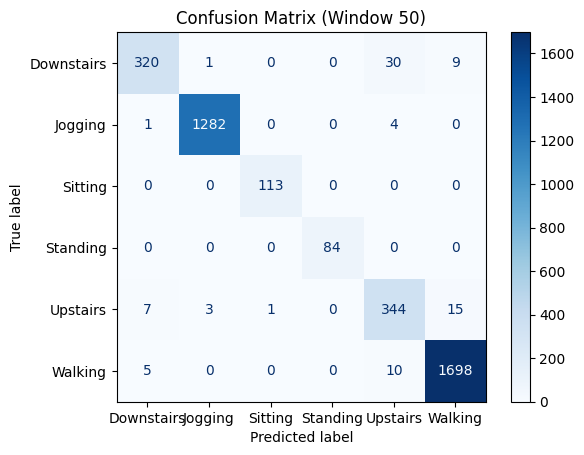


===== LSTM Training: Window Size 100 =====

[Window 100] Params: {'units': 64, 'dropout': 0.5, 'batch_size': 16}


/mnt/c/Users/Aayush/Desktop/Projects/SVMvsDL/ml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[Window 100] Val Acc: 0.9539 | Time: 134.85 sec

[Window 100] Best Params: {'units': 64, 'dropout': 0.5, 'batch_size': 16}
[Window 100] Test Accuracy: 0.9600
[Window 100] Best Training Time: 134.85 sec
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.83      0.84      0.83       177
     Jogging       0.98      1.00      0.99       615
     Sitting       1.00      1.00      1.00        60
    Standing       0.96      1.00      0.98        52
    Upstairs       0.90      0.77      0.83       198
     Walking       0.98      1.00      0.99       825

    accuracy                           0.96      1927
   macro avg       0.94      0.93      0.94      1927
weighted avg       0.96      0.96      0.96      1927



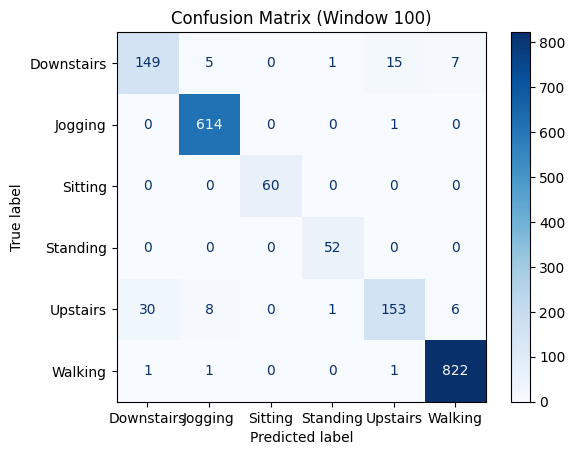

In [26]:
# Window Size 50
print("\n===== LSTM Training: Window Size 50 =====")
best_model_50, best_params_50 = train_best_lstm(
    X50_train, y50_train, X50_test, y50_test,
    window_size=50,
    params_list=params_list,
    label_encoder=label_encoder
)

# Window Size 100
print("\n===== LSTM Training: Window Size 100 =====")
best_model_100, best_params_100 = train_best_lstm(
    X100_train, y100_train, X100_test, y100_test,
    window_size=100,
    params_list=params_list,
    label_encoder=label_encoder
)

In [37]:
#CNN-LSTM HYBRID

In [31]:
params_list = [
    #{'units': 64, 'dropout': 0.3, 'batch_size': 32, 'filters': 32},
    #{'units': 128, 'dropout': 0.4, 'batch_size': 64, 'filters': 64},
    #{'units': 256, 'dropout': 0.5, 'batch_size': 128, 'filters': 64},
    {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32},
    {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32},
    {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64},
    {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64},
]


In [32]:
def build_cnn_lstm_model(input_shape, filters=64, units=64, dropout_rate=0.3, num_classes=6):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def train_best_cnn_lstm(X_train, y_train, X_test, y_test, window_size, params_list, label_encoder):
    best_val_acc = 0
    best_model = None
    best_params = {}
    best_train_time = 0

    input_shape = (window_size, 3)
    num_classes = y_train.shape[1]

    for params in params_list:
        print(f"\n[Window {window_size}] Params: {params}")
        model = build_cnn_lstm_model(input_shape, filters=params['filters'],
                                     units=params['units'], dropout_rate=params['dropout'],
                                     num_classes=num_classes)

        start = time.time()
        history = model.fit(X_train, y_train, epochs=10, batch_size=params['batch_size'],
                            validation_split=0.2, verbose=0)
        duration = time.time() - start
        val_acc = max(history.history['val_accuracy'])

        print(f"[Window {window_size}] Val Acc: {val_acc:.4f} | Time: {duration:.2f} sec")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_params = params
            best_train_time = duration

    test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n[Window {window_size}] Best Params: {best_params}")
    print(f"[Window {window_size}] Test Accuracy: {test_acc:.4f}")
    print(f"[Window {window_size}] Best Training Time: {best_train_time:.2f} sec")

    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"CNN-LSTM Confusion Matrix (Window {window_size})")
    plt.show()

    best_model.save(f"app/model/CNN_LSTM_model_{window_size}.h5")
    return best_model, best_params




[Window 50] Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}


/mnt/c/Users/Aayush/Desktop/Projects/SVMvsDL/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[Window 50] Val Acc: 0.9736 | Time: 95.55 sec

[Window 50] Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}
[Window 50] Val Acc: 0.9742 | Time: 91.69 sec

[Window 50] Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 50] Val Acc: 0.9723 | Time: 91.50 sec

[Window 50] Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 50] Val Acc: 0.9688 | Time: 140.20 sec

[Window 50] Best Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}
[Window 50] Test Accuracy: 0.9728
[Window 50] Best Training Time: 91.69 sec
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.86      0.97      0.91       360
     Jogging       0.99      1.00      0.99      1287
     Sitting       1.00      1.00      1.00       113
    Standing       1.00      0.96      0.98        84
    Upstairs       0.97      0.81      0.88       370
   

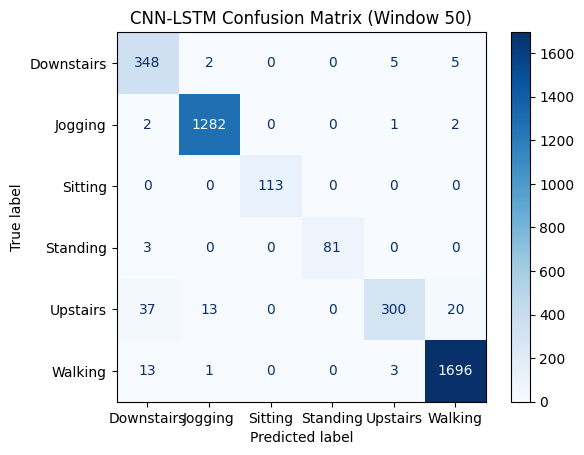


[Window 100] Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}


/mnt/c/Users/Aayush/Desktop/Projects/SVMvsDL/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[Window 100] Val Acc: 0.9714 | Time: 127.56 sec

[Window 100] Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}
[Window 100] Val Acc: 0.9760 | Time: 126.79 sec

[Window 100] Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 100] Val Acc: 0.9818 | Time: 133.37 sec

[Window 100] Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 100] Val Acc: 0.9682 | Time: 122.30 sec

[Window 100] Best Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 100] Test Accuracy: 0.9637
[Window 100] Best Training Time: 133.37 sec
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.94      0.90      0.92       177
     Jogging       0.95      1.00      0.98       615
     Sitting       1.00      1.00      1.00        60
    Standing       0.96      1.00      0.98        52
    Upstairs       0.87      0.91      0.89  

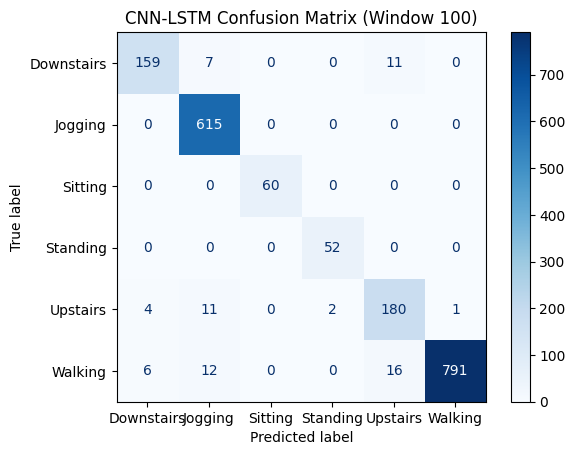

(<Sequential name=sequential_9, built=True>,
 {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64})

In [33]:
train_best_cnn_lstm(X50_train, y50_train, X50_test, y50_test, 50, params_list, label_encoder)
train_best_cnn_lstm(X100_train, y100_train, X100_test, y100_test, 100, params_list, label_encoder)


In [34]:
#DNN MODEL

In [35]:
dnn_params_list = [
    {'units': 64, 'dropout': 0.3, 'batch_size': 32},
    {'units': 64, 'dropout': 0.5, 'batch_size': 32},
    {'units': 64, 'dropout': 0.3, 'batch_size': 64},
    {'units': 64, 'dropout': 0.5, 'batch_size': 64},
    {'units': 64, 'dropout': 0.5, 'batch_size': 128},
    {'units': 128, 'dropout': 0.4, 'batch_size': 64},
    {'units': 256, 'dropout': 0.5, 'batch_size': 128},
]


In [36]:
def build_dnn_model(input_shape, units=128, dropout_rate=0.3, num_classes=6):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def train_best_dnn(X_train, y_train, X_test, y_test, window_size, params_list, label_encoder):
    best_val_acc = 0
    best_model = None
    best_params = {}
    best_train_time = 0

    input_shape = (window_size, 3)
    num_classes = y_train.shape[1]

    for params in params_list:
        print(f"\n[Window {window_size}] Params: {params}")
        model = build_dnn_model(input_shape=input_shape, units=params['units'], dropout_rate=params['dropout'],
                                num_classes=num_classes)

        start = time.time()
        history = model.fit(X_train, y_train, epochs=10, batch_size=params['batch_size'],
                            validation_split=0.2, verbose=0)
        duration = time.time() - start
        val_acc = max(history.history['val_accuracy'])

        print(f"[Window {window_size}] Val Acc: {val_acc:.4f} | Time: {duration:.2f} sec")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_params = params
            best_train_time = duration

    test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n[Window {window_size}] Best Params: {best_params}")
    print(f"[Window {window_size}] Test Accuracy: {test_acc:.4f}")
    print(f"[Window {window_size}] Best Training Time: {best_train_time:.2f} sec")

    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"DNN Confusion Matrix (Window {window_size})")
    plt.show()

    best_model.save(f"app/model/DNN_model_{window_size}.h5")
    return best_model, best_params



[Window 50] Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}


/mnt/c/Users/Aayush/Desktop/Projects/SVMvsDL/ml/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[Window 50] Val Acc: 0.9020 | Time: 23.39 sec

[Window 50] Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}
[Window 50] Val Acc: 0.8854 | Time: 26.60 sec

[Window 50] Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 50] Val Acc: 0.8609 | Time: 19.06 sec

[Window 50] Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 50] Val Acc: 0.8635 | Time: 15.90 sec

[Window 50] Best Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}
[Window 50] Test Accuracy: 0.9086
[Window 50] Best Training Time: 23.39 sec
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.69      0.72      0.70       360
     Jogging       0.97      0.98      0.97      1287
     Sitting       1.00      0.89      0.94       113
    Standing       0.87      1.00      0.93        84
    Upstairs       0.76      0.59      0.66       370
     

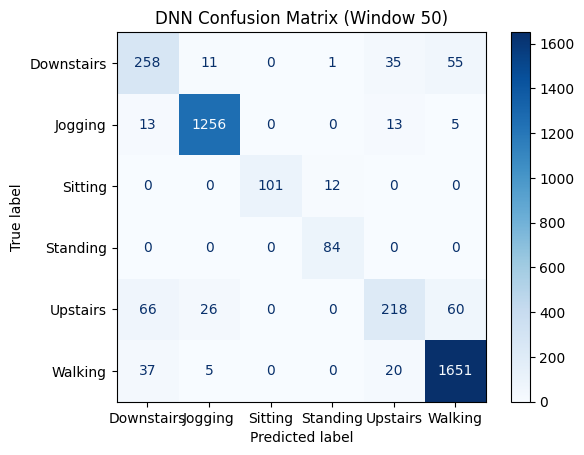

/mnt/c/Users/Aayush/Desktop/Projects/SVMvsDL/ml/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



[Window 100] Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}
[Window 100] Val Acc: 0.8592 | Time: 9.05 sec

[Window 100] Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}
[Window 100] Val Acc: 0.8443 | Time: 8.78 sec

[Window 100] Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 100] Val Acc: 0.8274 | Time: 10.58 sec

[Window 100] Params: {'units': 128, 'dropout': 0.5, 'batch_size': 32, 'filters': 64}
[Window 100] Val Acc: 0.8164 | Time: 9.58 sec

[Window 100] Best Params: {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32}
[Window 100] Test Accuracy: 0.8677
[Window 100] Best Training Time: 9.05 sec
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.68      0.28      0.40       177
     Jogging       0.96      0.99      0.97       615
     Sitting       1.00      0.87      0.93        60
    Standing       0.69

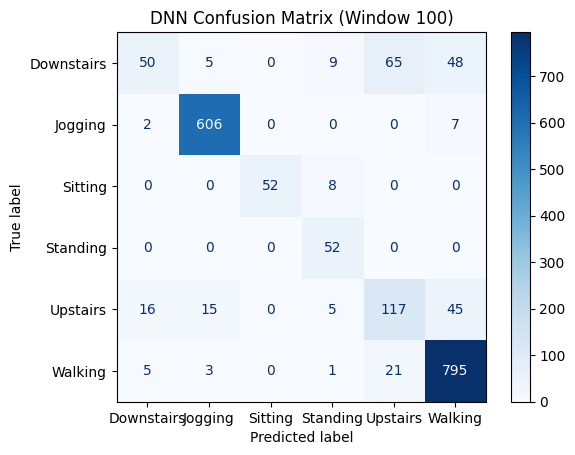

(<Sequential name=sequential_15, built=True>,
 {'units': 128, 'dropout': 0.3, 'batch_size': 32, 'filters': 32})

In [37]:
train_best_dnn(X50_train, y50_train, X50_test, y50_test, 50, params_list, label_encoder)
train_best_dnn(X100_train, y100_train, X100_test, y100_test, 100, params_list, label_encoder)


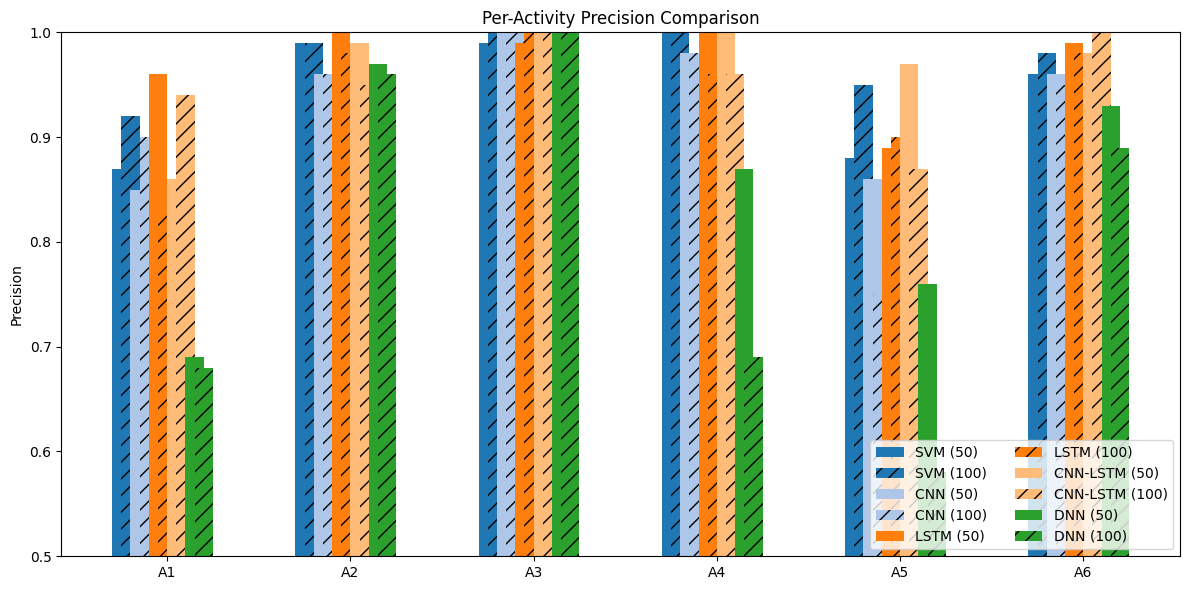

In [53]:
import matplotlib.pyplot as plt
import numpy as np

activities = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']
models = ['SVM', 'CNN', 'LSTM', 'CNN-LSTM', 'DNN']
window_sizes = ['50', '100']
colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c']
hatch_styles = ['', '//']  # One for each window size

precision_scores = {
    'SVM': [ [0.87, 0.99, 0.99, 1.00, 0.88, 0.96], [0.92, 0.99, 1.00, 1.00, 0.95, 0.98] ],
    'CNN': [ [0.85, 0.96, 1.00, 0.98, 0.86, 0.96], [0.90, 0.96, 1.00, 0.98, 0.75, 0.95] ],
    'LSTM': [[0.96, 1.00, 0.99, 1.00, 0.89, 0.99], [0.83, 0.98, 1.00, 0.96, 0.90, 0.98] ],
    'CNN-LSTM': [[0.86, 0.99, 1.00, 1.00, 0.97, 0.98], [0.94, 0.95, 1.00, 0.96, 0.87, 1.00]],
    'DNN' : [[0.69, 0.97, 1.00, 0.87, 0.76, 0.93], [0.68, 0.96, 1.00, 0.69, 0.58, 0.89]],
    
}

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.1
x = np.arange(len(activities))

for i, model in enumerate(models):
    for j, window in enumerate(window_sizes):
        offset = (i * 2 + j - 5) * bar_width / 2
        scores = precision_scores[model][j]
        ax.bar(x + offset, scores, width=bar_width, color=colors[i], label=f'{model} ({window})', hatch=hatch_styles[j])

ax.set_xticks(x)
ax.set_xticklabels(activities)
ax.set_ylim(0.5, 1)
ax.set_ylabel("Precision")
ax.set_title("Per-Activity Precision Comparison")
ax.legend(loc='lower right', ncol=2)
plt.tight_layout()
plt.savefig("precision_plot.pdf")  # Include in LaTeX
plt.show()


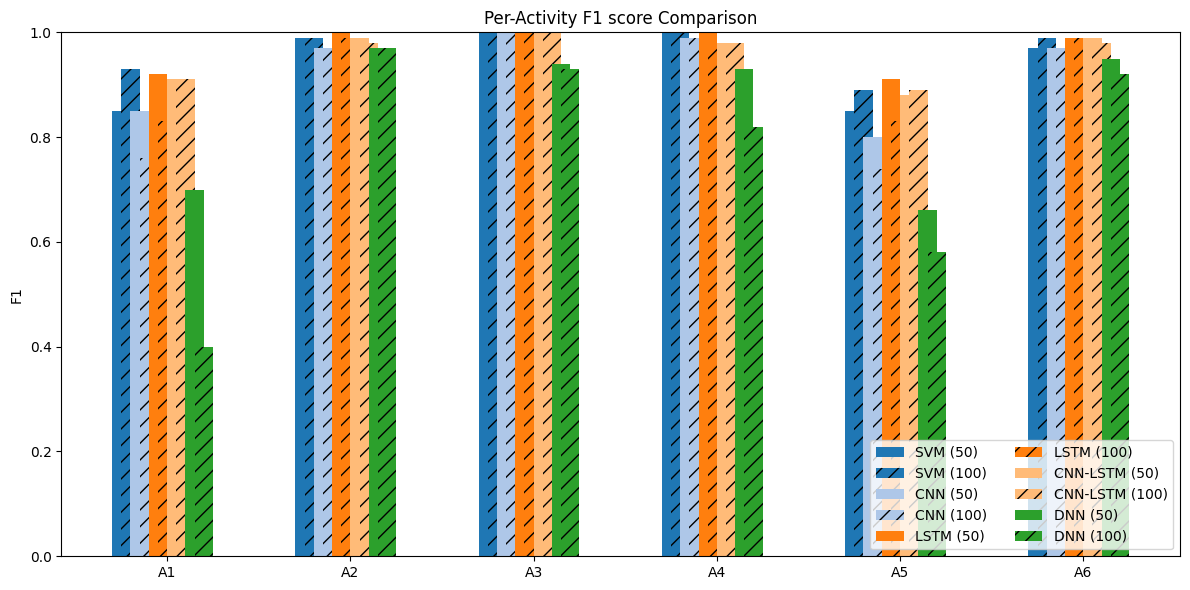

In [51]:

activities = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']
models = ['SVM', 'CNN', 'LSTM', 'CNN-LSTM', 'DNN']
window_sizes = ['50', '100']
colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c']
hatch_styles = ['', '//']  # One for each window size
f1_scores = {
    'SVM': [[0.85, 0.99, 1.00, 1.00, 0.85, 0.97], [0.93, 0.99, 1.00, 1.00, 0.89, 0.99]],
    'CNN': [[0.85, 0.97, 1.00, 0.99, 0.80, 0.97], [0.76, 0.97, 1.00, 0.99, 0.74, 0.97]],
    'LSTM': [[0.92, 1.00, 1.00, 1.00, 0.91, 0.99], [0.83, 0.99, 1.00, 0.98, 0.83, 0.99]],
    'CNN-LSTM': [[0.91, 0.99, 1.00, 0.98, 0.88, 0.99], [0.91, 0.98, 1.00, 0.98, 0.89, 0.98]],
    'DNN' : [[0.70, 0.97, 0.94, 0.93, 0.66, 0.95], [0.40, 0.97, 0.93, 0.82, 0.58, 0.92]],
    
}

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.1
x = np.arange(len(activities))

for i, model in enumerate(models):
    for j, window in enumerate(window_sizes):
        offset = (i * 2 + j - 5) * bar_width / 2
        scores = f1_scores[model][j]
        ax.bar(x + offset, scores, width=bar_width, color=colors[i], label=f'{model} ({window})', hatch=hatch_styles[j])

ax.set_xticks(x)
ax.set_xticklabels(activities)
ax.set_ylim(0, 1)
ax.set_ylabel("F1")
ax.set_title("Per-Activity F1 score Comparison")
ax.legend(loc='lower right', ncol=2)
plt.tight_layout()
plt.savefig("f1_plot.pdf")  # Include in LaTeX
plt.show()
